# Ensemble - Bagging

## References

https://www.kaggle.com/datasets/teejmahal20/airline-passenger-satisfaction

## Import Python Libraries

In [299]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif, RFE, SelectFromModel
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler, MinMaxScaler
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, RocCurveDisplay
from sklearn.utils import resample

## Global Variables

In [211]:
# random state 
random_state = 4781
# random_state = 7644

# colors
c_scale = 256
c1 = (1, 1, 1) # grey
c2 = (1, 0, 0) # red
c3 = (181/c_scale, 204/c_scale, 6/c_scale) # yellow
c4 = (6/c_scale, 122/c_scale, 204/c_scale) # blue
c5 = (0, 0, 0) # black

## Import Dataset

In [212]:
# Source: https://www.kaggle.com/datasets/johnsmith88/heart-disease-dataset

# Dataset Column Overview: 
# ------------------------------------------------------------------------------

# X01: age
# X02: sex
# X03: chest pain type (4 values)
# X04: resting blood pressure
# X05: serum cholestoral in mg/dl
# X06: fasting blood sugar > 120 mg/dl
# X07: resting electrocardiographic results (values 0,1,2)
# X08: maximum heart rate achieved
# X09: exercise induced angina
# X10: oldpeak = ST depression induced by exercise relative to rest
# X11: the slope of the peak exercise ST segment
# X12: number of major vessels (0-3) colored by flourosopy
# X13: thal: 0 = normal; 1 = fixed defect; 2 = reversable defect
#   Y: target: presence of heart disease, 0 = no disease and 1 = disease.

In [213]:
# load dataset from github
filepath1 = 'https://raw.githubusercontent.com/notfakearcher/julian/main/02_data/heart.csv'
df0 = pd.read_csv(filepath1, header = 0)
df0.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [214]:
# identify X_cols and y_col
all_cols = df0.columns.values.copy()
y_col = 'target'
cond1 = all_cols != y_col
X_cols = all_cols[cond1]

In [215]:
# standardize column names
df1 = df0.copy()
zeros = len(str(len(X_cols)))
new_all_cols = all_cols
temp = (np.arange(0, len(X_cols)) + 1).astype('str')

new_y_col = 'y'
new_X_cols = ['X' + i.zfill(zeros) for i in temp]

new_all_cols[cond1] = new_X_cols
new_all_cols[~cond1] = new_y_col

df1.columns = new_all_cols

df1.head()

,X01,X02,X03,X04,X05,X06,X07,X08,X09,X10,X11,X12,X13,y
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [216]:
# check data structure
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X01     1025 non-null   int64  
 1   X02     1025 non-null   int64  
 2   X03     1025 non-null   int64  
 3   X04     1025 non-null   int64  
 4   X05     1025 non-null   int64  
 5   X06     1025 non-null   int64  
 6   X07     1025 non-null   int64  
 7   X08     1025 non-null   int64  
 8   X09     1025 non-null   int64  
 9   X10     1025 non-null   float64
 10  X11     1025 non-null   int64  
 11  X12     1025 non-null   int64  
 12  X13     1025 non-null   int64  
 13  y       1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


In [217]:
# describe data
df1.describe()

,X01,X02,X03,X04,X05,X06,X07,X08,X09,X10,X11,X12,X13,y
count,1025.000000,1025.000000,1025.000000,1025.000000,1025.00000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000
mean,54.434146,0.695610,0.942439,131.611707,246.00000,0.149268,0.529756,149.114146,0.336585,1.071512,1.385366,0.754146,2.323902,0.513171
std,9.072290,0.460373,1.029641,17.516718,51.59251,0.356527,0.527878,23.005724,0.472772,1.175053,0.617755,1.030798,0.620660,0.500070
min,29.000000,0.000000,0.000000,94.000000,126.00000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,0.000000,0.000000,120.000000,211.00000,0.000000,0.000000,132.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,56.000000,1.000000,1.000000,130.000000,240.00000,0.000000,1.000000,152.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,275.00000,0.000000,1.000000,166.000000,1.000000,1.800000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.00000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [218]:
# check missing values
df1.isna().sum()

X01    0
X02    0
X03    0
X04    0
X05    0
X06    0
X07    0
X08    0
X09    0
X10    0
X11    0
X12    0
X13    0
y      0
dtype: int64

## Data Cleaning and Transformation

In [219]:
# response column
y_col = new_y_col
y_col

'y'

In [220]:
# predictor columns
cond1 = df1.columns != y_col
X_cols = df1.columns[cond1]
X_cols

Index(['X01', 'X02', 'X03', 'X04', 'X05', 'X06', 'X07', 'X08', 'X09', 'X10',
       'X11', 'X12', 'X13'],
      dtype='object')

In [221]:
# get unique y_labels
y_labels = ['normal', 'fixed defect', 'reversable defect']
y_labels = {y_labels[i]: i for i in range(len(y_labels))}
# y_labels = {i:y_labels[i] for i in range(len(y_labels))}
y_labels

{'normal': 0, 'fixed defect': 1, 'reversable defect': 2}

In [222]:
# rename y_labels
df1.y = df1.y.replace(y_labels)
df1.head()

,X01,X02,X03,X04,X05,X06,X07,X08,X09,X10,X11,X12,X13,y
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [223]:
# remove rows with missing valus
for X in X_cols:
  cond1 = ~((df1[X].isna()))
  df1 = df1.loc[cond1,:]
  
df1.isna().sum()

X01    0
X02    0
X03    0
X04    0
X05    0
X06    0
X07    0
X08    0
X09    0
X10    0
X11    0
X12    0
X13    0
y      0
dtype: int64

In [224]:
# encode categorical values to numerical values
le = LabelEncoder()

categorical_cols = df1[X_cols].select_dtypes("object").columns
df1[categorical_cols] = df1[categorical_cols].apply(le.fit_transform)

df1.head()

,X01,X02,X03,X04,X05,X06,X07,X08,X09,X10,X11,X12,X13,y
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [225]:
# # check label distribution
# temp = list(y_labels.values())
# cond1 = df1.y == temp[0]
# cond2 = df1.y == temp[1]

# n_1 = np.sum(cond1)
# print(temp[0])
# print(n_1)

# n_2 = np.sum(cond2)
# print(temp[1])
# print(n_2)

# # upsample minority label
# df_temp = df1.loc[cond2,:]
# n_diff = n_1 - n_2
# print(n_diff)

# df_upsample = resample(
#   df_temp,
#   replace = True,
#   n_samples = n_diff,
#   random_state = random_state
# )

# # update df1
# df1 = pd.concat([df1, df_upsample], ignore_index = True)
# df1.info()

In [226]:
# # check label distribution
# temp = list(y_labels.values())
# cond1 = df1.y == temp[0]
# cond2 = df1.y == temp[1]

# n_1 = np.sum(cond1)
# print(temp[0])
# print(n_1)

# n_2 = np.sum(cond2)
# print(temp[1])
# print(n_2)

# # downsample majority label
# df_temp = df1.loc[cond1,:]
# n_diff = n_1 - n_2
# print(n_diff)

# df_upsample = resample(
#   df_temp,
#   replace = False,
#   n_samples = n_diff,
#   random_state = random_state
# )

# # # update df1
# df1 = df1.drop(df_upsample.index)
# df1.info()

In [227]:
# normalize all X_cols
df2 = df1.copy()
norm = StandardScaler()
# norm = MinMaxScaler()
# norm = RobustScaler()
df2[X_cols] = norm.fit_transform(df2[X_cols])

df2.head()

,X01,X02,X03,X04,X05,X06,X07,X08,X09,X10,X11,X12,X13,y
0,-0.268437,0.661504,-0.915755,-0.377636,-0.659332,-0.418878,0.891255,0.821321,-0.712287,-0.060888,0.995433,1.209221,1.089852,0
1,-0.158157,0.661504,-0.915755,0.479107,-0.833861,2.387330,-1.004049,0.255968,1.403928,1.727137,-2.243675,-0.731971,1.089852,0
2,1.716595,0.661504,-0.915755,0.764688,-1.396233,-0.418878,0.891255,-1.048692,1.403928,1.301417,-2.243675,-0.731971,1.089852,0
3,0.724079,0.661504,-0.915755,0.936037,-0.833861,-0.418878,0.891255,0.516900,-0.712287,-0.912329,0.995433,0.238625,1.089852,0
4,0.834359,-1.511706,-0.915755,0.364875,0.930822,2.387330,0.891255,-1.874977,-0.712287,0.705408,-0.624121,2.179817,-0.522122,0


In [228]:
# # remove outliers from each column
# for X in X_cols:
#   cond1 = ~((df2[X] >= 3) | (df2[X] <= -3))
#   df2 = df2.loc[cond1,:]
  
# df2.info()

In [229]:
# # melt df2 into a dataframe where cols become stacked as rows
# df3 = df2.melt(
#   id_vars = y_col,
#   value_vars = X_cols,
#   var_name = 'X',
#   value_name = "X_value"
# )
# df3.head()

## Visualize Dataset

In [230]:
# figure setup
fig_cols = 3
fig_rows = np.ceil(len(X_cols)/fig_cols).astype('int')
y_max = np.round(df2[X_cols].max().max(), 0)
y_min = np.round(df2[X_cols].min().min(), 0)
n_levels = df2.y.unique().size
palette1 = [c1 for i in range(n_levels)]
palette2 = [c3, c4]
figsize = (20, 20)

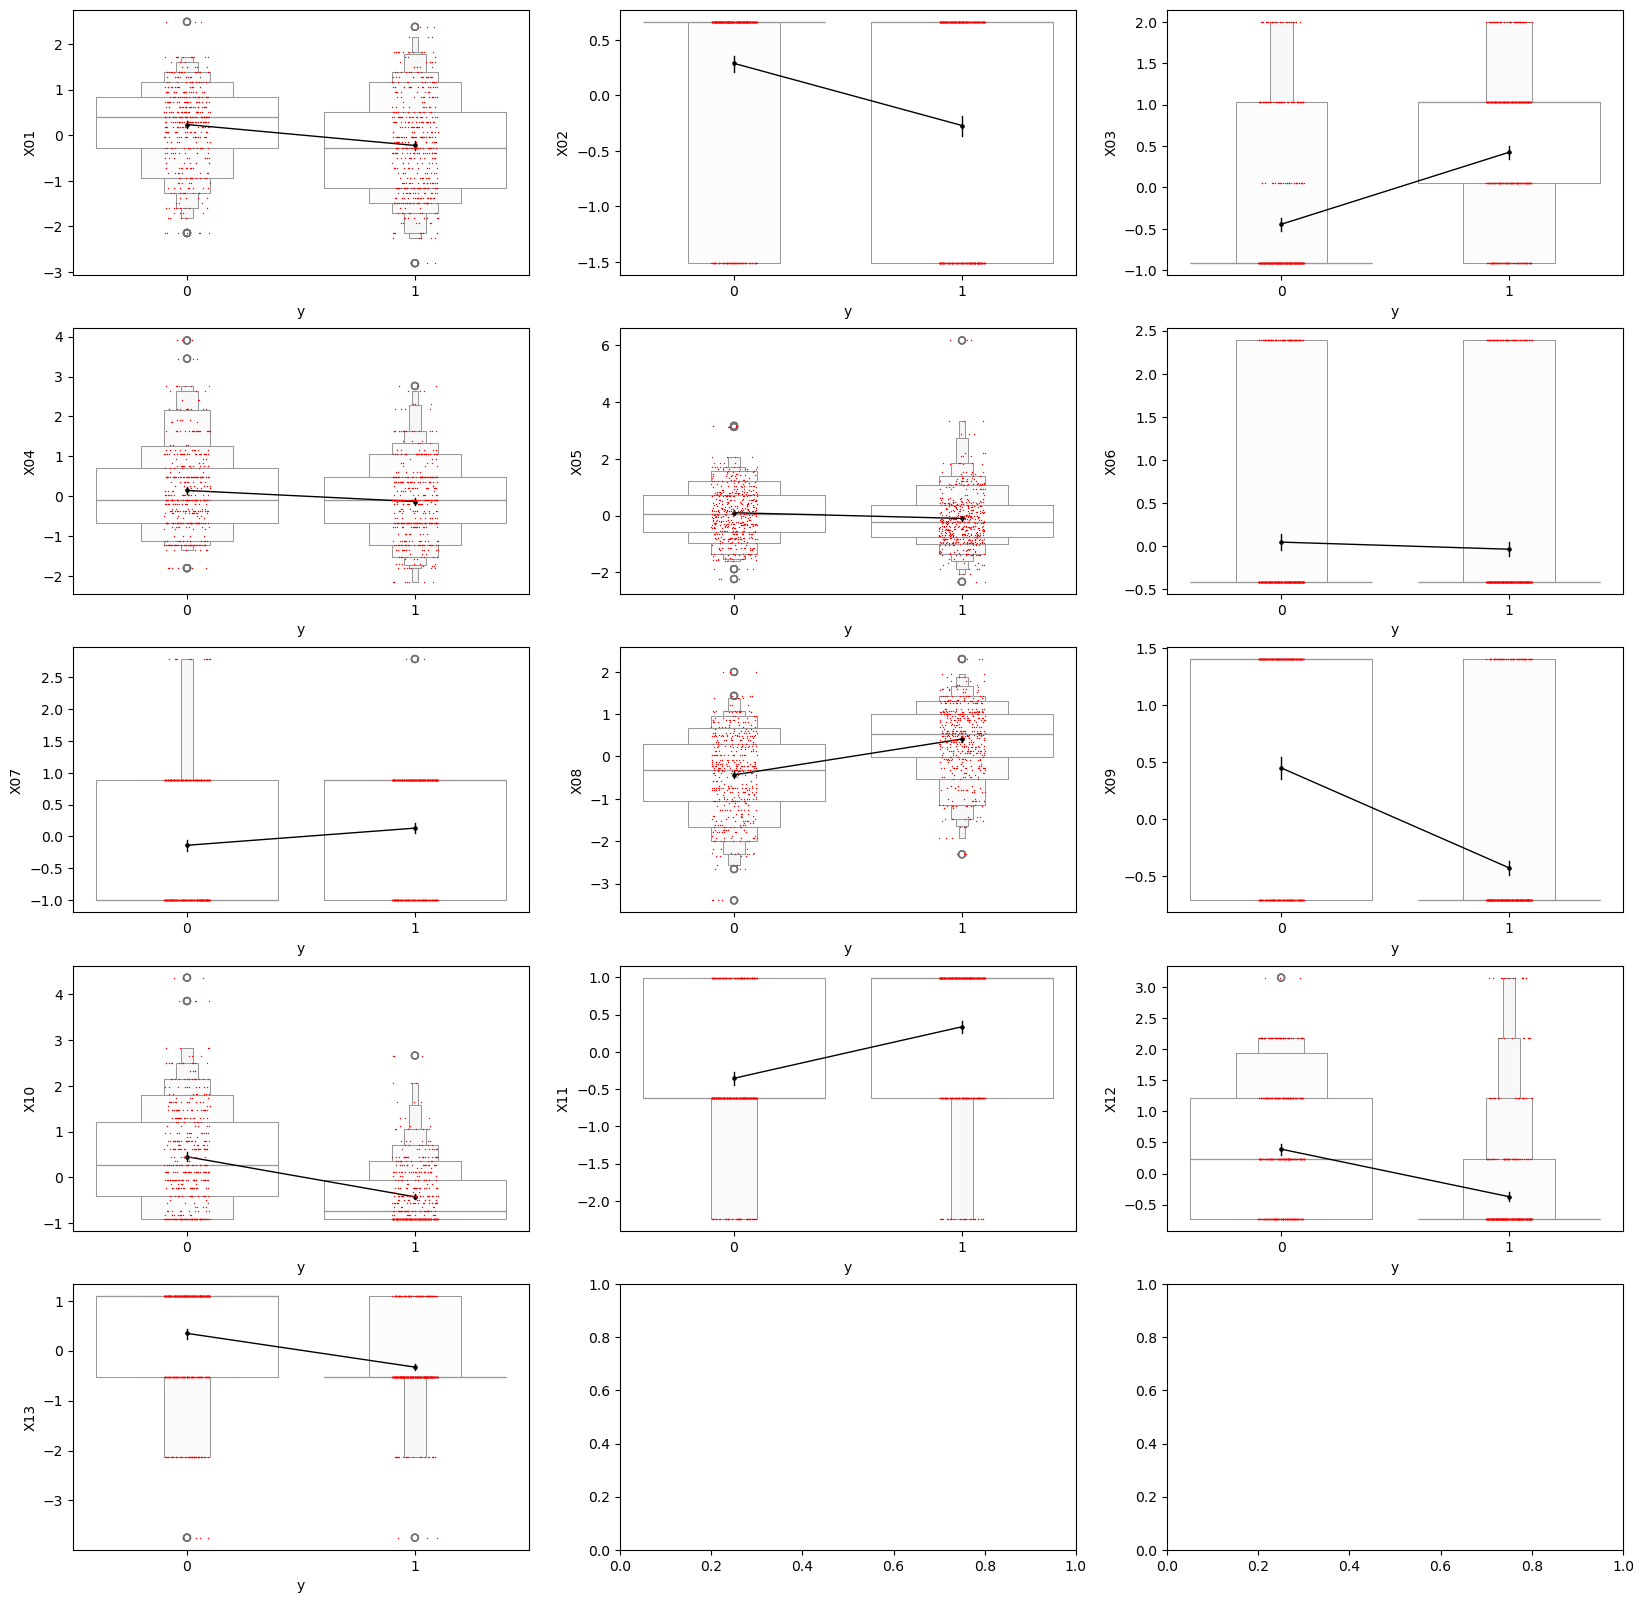

In [231]:
# subplot of y vs each X (stripplot + violinplot + boxenplot)
f1, axes = plt.subplots(fig_rows, fig_cols, figsize = figsize)
itr = 0
for x in X_cols:
  row = np.floor(itr/fig_cols) 
  row = row.astype('int')
  col = np.mod(itr, fig_cols)
  col = col.astype('int') 
  # print(row)
  # print(col)
  # p1 = sns.violinplot(ax = axes[row, col], data = df2, x = y_col, y = x, hue = y_col, palette = palette1)
  p2 = sns.boxenplot(ax = axes[row, col], data = df2, x = y_col, y = x, hue = y_col, palette = palette1)
  p3 = sns.stripplot(ax = axes[row, col], data = df2, x = y_col, y = x, color = c2, size = 1)
  p4 = sns.pointplot(ax = axes[row, col], data = df2, x = y_col, y = x, color = c5, linewidth = 1)
  axes[row, col].legend_ = None
  # axes[row, col].set_ylim(y_min, y_max)
  itr = itr + 1

## Feature Selection

### Remove Features Having % Similar Values or More

In [232]:
# porportion similar (p)
p = 1
# porportion dissimilar (q = 1- p)
q = 1 - p

print(p,q)

1 0


In [233]:
# initialize variance threshold model (based on porportion dissimilar)
myfit = VarianceThreshold(q)

In [234]:
# fit model
temp = myfit.fit_transform(df2[X_cols])
temp.shape

(1025, 13)

In [235]:
# get columns that have at least p-similar or q-disimilar values
X_cols_var_threshold = myfit.get_feature_names_out()
X_cols_var_threshold

array(['X01', 'X02', 'X03', 'X04', 'X05', 'X06', 'X07', 'X08', 'X09',
       'X10', 'X11', 'X12', 'X13'], dtype=object)

In [236]:
# update X_cols
X_cols = X_cols_var_threshold
X_cols

array(['X01', 'X02', 'X03', 'X04', 'X05', 'X06', 'X07', 'X08', 'X09',
       'X10', 'X11', 'X12', 'X13'], dtype=object)

### Select Features Using Model Selection Methods

In [237]:
# seperate data into X and y
X = df2[X_cols]
y = np.ravel(df2[y_col])

In [238]:
# estimator model
estimator_model = RandomForestClassifier(
  n_estimators = 10,
  # max_depth = 100,
  criterion = 'gini',
  random_state = random_state
)    

In [239]:
# fit estimmator model
temp = estimator_model.fit(X, y)

In [240]:
# feature importance values
feature_importance = estimator_model.feature_importances_
feature_importance

array([0.07552598, 0.0289973 , 0.11954126, 0.07155633, 0.06942741,
       0.01197026, 0.02388216, 0.09384218, 0.07396191, 0.09846234,
       0.0471094 , 0.14439337, 0.14133009])

In [241]:
# threshold feature importance
# feature_importance_threshold = np.mean(feature_importance)
feature_importance_threshold = np.median(feature_importance)
# feature_importance_threshold = np.quantile(feature_importance, q = 0.75)
feature_importance_threshold

0.07396191358445553

In [242]:
# initialize SelectFromModel
myfit = SelectFromModel(
  estimator = estimator_model,
  threshold = feature_importance_threshold
)

In [243]:
# fit SelectFromModel
temp = myfit.fit_transform(X, y)

In [244]:
# get columns kept from ensemble - random forest feature selection
X_cols_rf = myfit.get_feature_names_out()
X_cols_rf

array(['X01', 'X03', 'X08', 'X09', 'X10', 'X12', 'X13'], dtype=object)

## Train and Test ML Model

In [290]:
# X_cols to include after feature selection
# X_include = X.columns
X_include = X_cols_rf
print(len(X_include))
print(X_include)

7
['X01' 'X03' 'X08' 'X09' 'X10' 'X12' 'X13']


In [344]:
# split data into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X[X_include], y, 
  stratify = y, shuffle = True, 
  train_size = 0.8, random_state = random_state
)

In [358]:
# initialize estimtor model 
estimator_model = DecisionTreeClassifier(
  random_state = random_state
)

In [359]:
# initialize Bagging Model
myfit = BaggingClassifier(
  estimator = estimator_model,
  n_estimators = 10, 
  random_state = random_state
)

In [360]:
# fit model
temp = myfit.fit(X_train, y_train)

In [361]:
# get predictions on test data
y_hat = myfit.predict(X_test)

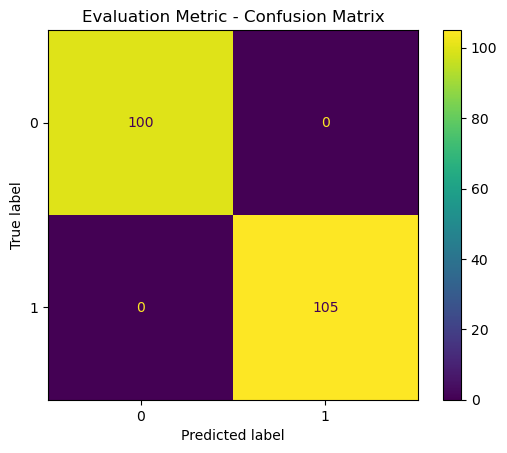

In [362]:
# model evaluation - confusion matrix

# get confusion matrix
cm = confusion_matrix(
  y_true = y_test,
  y_pred = y_hat
)

# show confusion matrix visual
labels = myfit.classes_
p1 = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = labels)
p1.plot()
plt.title('Evaluation Metric - Confusion Matrix')
plt.show()

In [363]:
# model evaluation - recall, precision , F1-score
metric_report = classification_report(y_true = y_test, y_pred = y_hat, output_dict = False, zero_division = 0) 
print(metric_report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       105

    accuracy                           1.00       205
   macro avg       1.00      1.00      1.00       205
weighted avg       1.00      1.00      1.00       205



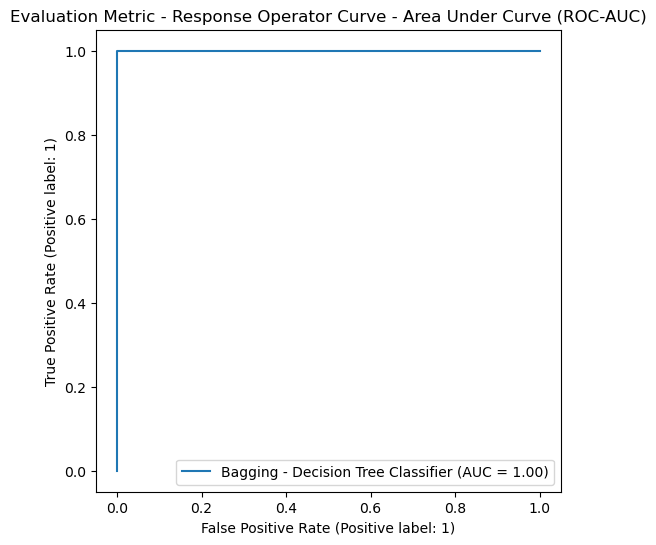

In [365]:
# model evaluation - AUC
fig, ax = plt.subplots(figsize = (6, 6))
RocCurveDisplay.from_predictions(ax = ax,
  y_true = y_test, y_pred = y_hat, pos_label = 1,
  name = "Bagging - Decision Tree Classifier"
)
plt.title('Evaluation Metric - Response Operator Curve - Area Under Curve (ROC-AUC)')
plt.show()